In [1]:
import random
import textwrap

import numpy as np
from PIL import Image, ImageDraw, ImageFont

import sys
sys.path.append(".")
import clipfolder as clip

import json
import os
import cv2
import pandas as pd


import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import tqdm
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader


Img_MEAN = (0.48145466, 0.4578275, 0.40821073)
Img_STD = (0.26862954, 0.26130258, 0.27577711)

mu = torch.tensor(Img_MEAN).view(3, 1, 1).cuda()
std = torch.tensor(Img_STD).view(3, 1, 1).cuda()

def denormalize(X):
    return X * std + mu

which_layer=-1


with open("descriptors.json", 'r') as f:
    des = json.load(f)
    
def construct_prompt(des):
    ans = []
    for each in des.keys():
        ans.append(each)
        for com in des[each]:
            ans.append(com)
    return ans

model_list = []

# device_list = [torch.device("cuda:0")] * 4 + \
#                 [torch.device("cuda:1")] * 4 + \
#                 [torch.device("cuda:2")] * 4 + \
#                 [torch.device("cuda:3")] * 5

device_list = [torch.device("cuda:0")] * 13
for which_layer in range(0, 13):
    model, preprocess = clip.load('ViT-B/32', device_list[which_layer], jit=False, extract_last_k_th_token=which_layer)
    model_list.append(model)






transofmer total layers 12





transofmer total layers 12





transofmer total layers 12
 mask for layer 11





transofmer total layers 12





transofmer total layers 12
 mask for layer 10
 mask for layer 11





transofmer total layers 12





transofmer total layers 12
 mask for layer 9
 mask for layer 10
 mask for layer 11





transofmer total layers 12





transofmer total layers 12
 mask for layer 8
 mask for layer 9
 mask for layer 10
 mask for layer 11





transofmer total layers 12





transofmer total layers 12
 mask for layer 7
 mask for layer 8
 mask for layer 9
 mask for layer 10
 mask for layer 11





transofmer total layers 12





transofmer total layers 12
 mask for layer 6
 mask for layer 7
 mask for layer 8
 mask for layer 9
 mask for layer 10
 mask for layer 11





transofmer total layers 12





transofmer total layers 12
 mask for layer 5
 mask for layer 6
 mask for layer 7
 mask for layer 8
 mask for layer 9
 mask for layer 10
 mask for layer 11





In [3]:
#Use this function if vocabulary is too large
def get_texts_all_layers_chunk(image_input, text_feas = None):

    if text_feas is None:
        text_feas = [None] * len(texts_list)

    text_logits_list_wordcat = []
    for texts_idx, texts in enumerate(texts_list):
        logits_list_layers = []

        images = image_input
        

        with autocast():
            with torch.no_grad():
                result_tmp = []
                for model_idx, each_model in enumerate(model_list):
                    
                    if text_feas[texts_idx] != None:
                        text_tokens = clip.tokenize(["placeholder"], truncate = True).to(device_list[model_idx])
                        image_fea, _text_fea = each_model(images, text_tokens, get_all_last=True)
                    else: 
                        chunk_size = 1000
                        text_chunks = [texts[i:i+chunk_size] for i in range(0, len(texts), chunk_size)]
                        text_fea_list = []

                        for chunk in text_chunks:
                            text_tokens = clip.tokenize(chunk, truncate=True).to(device_list[model_idx])
                            image_fea, _text_fea = each_model(images, text_tokens, get_all_last=True)
                            text_fea_list.append(_text_fea)
                        
                        text_feas[texts_idx] = torch.cat(text_fea_list, dim=0)
                    
                    selected_interprets = []

                    image_fea, _text_fea = each_model(images.to(device_list[model_idx]), text_tokens, get_all_last=True)
                    if text_feas[texts_idx] is None:
                        text_feas[texts_idx] = _text_fea

                    logits_per_image = image_fea @ text_feas[texts_idx].t()
                    logits_list_layers.append(logits_per_image)

        text_logits_list_wordcat.append(logits_list_layers)

    for i in range(len(texts_list)):
        for j in range(13):
            text_logits_list_wordcat[i][j] = text_logits_list_wordcat[i][j].cpu().numpy()

    categories = ["noun phrases", "adjectives", "nouns only"]
    series = []
    category_mean = np.zeros(len(categories))
    for ind, category in enumerate(categories):
        one_series = []
        for layer in range(13):
            category_mean[ind] += np.mean(text_logits_list_wordcat[ind][layer])
            # print(f"{category} layer {layer} {logits_list_wordcat[ind][12-layer].mean()}")
            one_series.append(text_logits_list_wordcat[ind][12-layer].mean())
        series.append(one_series)

    category_mean /= 13

    nouns_texts_start = 0
    nouns_texts_end = len(nouns_prompts)
    adjs_texts_start = nouns_texts_end
    adjs_texts_end = adjs_texts_start + len(adjs_prompts)
    nouns_only_texts_start = adjs_texts_end
    nouns_only_texts_end = nouns_only_texts_start + len(nouns_only_prompts)


    text_fea_result = []
    result_tmp = []

    max_logits_per_image_list = []

    for model_idx, each_model in enumerate(model_list):

        selected_interpret = []

        logits_per_image_list = [text_logits_list_wordcat[i][model_idx] for i in range(len(text_logits_list_wordcat))]
        logits_per_image = np.concatenate(logits_per_image_list, axis=2)

        logits_per_image[:, :, nouns_texts_start:nouns_texts_end] -= 10000#category_mean[0]
        logits_per_image[:, :, adjs_texts_start:adjs_texts_end] -= category_mean[1]
        logits_per_image[:, :, nouns_only_texts_start:nouns_only_texts_end] -= category_mean[2]

        pseudo_target = np.argmax(logits_per_image, axis=2)
        
        for it in range(pseudo_target.shape[1]): # for each token
            index = pseudo_target[0, it]
            # print(index)
            selected_interpret.append(ans_with_cat[index])
        result_tmp.append((None, selected_interpret))

    text_fea_result.append(result_tmp)

    text_texts_all_layers = []

    for layer in range(13):
        texts_layer = text_fea_result[0][12-layer][1]
        text_texts_all_layers.append(texts_layer)

    return text_texts_all_layers, text_feas


def get_texts_all_layers(image_input, text_feas = None):

    if text_feas is None:
        text_feas = [None] * len(texts_list)

    text_logits_list_wordcat = []
    for texts_idx, texts in enumerate(texts_list):
        logits_list_layers = []

        images = image_input
        text_tokens = clip.tokenize(texts, truncate = True).to(device_list[0])

        with autocast():
            with torch.no_grad():
                result_tmp = []
                for each_model in model_list:

                    if text_feas[texts_idx] != None:
                        text_tokens = clip.tokenize(["placeholder"], truncate = True).to(device_list[0])
                    selected_interprets = []

                    image_fea, _text_fea = each_model(images, text_tokens, get_all_last=True)
                    if text_feas[texts_idx] is None:
                        text_feas[texts_idx] = _text_fea

                    logits_per_image = image_fea @ text_feas[texts_idx].t()
                    logits_list_layers.append(logits_per_image)

        text_logits_list_wordcat.append(logits_list_layers)

    for i in range(len(texts_list)):
        for j in range(13):
            text_logits_list_wordcat[i][j] = text_logits_list_wordcat[i][j].cpu().numpy()


    series = []
    category_mean = np.zeros(len(texts))
    for ind, category in enumerate(texts_list):
        one_series = []
        for layer in range(13):
            category_mean[ind] += np.mean(text_logits_list_wordcat[ind][layer])
            # print(f"{category} layer {layer} {logits_list_wordcat[ind][12-layer].mean()}")
            one_series.append(text_logits_list_wordcat[ind][12-layer].mean())
        series.append(one_series)

    category_mean /= 13

    start_list = []
    end_list = []
    c = 0
    for ind, category in enumerate(texts_list):
        start_list.append(c)
        c += len(category)
        end_list.append(c)

    text_fea_result = []
    result_tmp = []

    max_logits_per_image_list = []

    for model_idx, each_model in enumerate(model_list):

        selected_interpret = []

        logits_per_image_list = [text_logits_list_wordcat[i][model_idx] for i in range(len(text_logits_list_wordcat))]
        logits_per_image = np.concatenate(logits_per_image_list, axis=2)

        for ind, category in enumerate(texts_list):
            logits_per_image[:, :, start_list[ind]:end_list[ind]] -= category_mean[ind]
            pass

        pseudo_target = np.argmax(logits_per_image, axis=2)
        
        for it in range(pseudo_target.shape[1]): # for each token
            index = pseudo_target[0, it]
            # print(index)
            selected_interpret.append(ans_with_cat[index])
        result_tmp.append((None, selected_interpret))

    text_fea_result.append(result_tmp)

    text_texts_all_layers = []

    for layer in range(13):
        texts_layer = text_fea_result[0][12-layer][1]
        text_texts_all_layers.append(texts_layer)

    return text_texts_all_layers, text_feas

In [ ]:
#celeb A
import os
import random

directory = '/local/rcs/hc3295/celebA/img_align_celeba/img_align_celeba/'

file_list = os.listdir(directory)
image_files = [file for file in file_list if file.endswith(('.jpg', '.jpeg', '.png'))]
random_image = random.choice(image_files) #"151218.jpg"#

# Print the randomly selected image file
print(random_image)
img = Image.open(directory + '/' + random_image).convert("RGB") # you can use PIL to open the image

original_image = np.array(img)
original_image = Image.fromarray(original_image)

original_images = [preprocess(original_image)]
original_image_input = torch.tensor(np.stack(original_images)).to(device_list[0])
original_image_arr = np.array(original_image)
plt.imshow(original_image)

detect_words = ["face", "gender", "male", "female", "man", "men", "woman", "women", "sex", "boy", "girl", "man face", "woman face", "face", "nose", "eyes", "breast", "shoulder", 'mouth', 'ears', 'shoulders', 'shirt', 'jacket', 'tie', 'scarf', 'watch', 'hat', 'eyebrows', 'lashes', 'iris', 'pupils', 'nostrils', 'lips', 'teeth', 'tongue', 'temples', 'cheeks', 'cheekbones', 'chin', 'throat', 'arms', 'elbows', 'wrists', 'hands', 'fingers', 'chest', 'sternum', 'ribs', 'blouse', 'sweater', 'hoodie', 'blazer', 'pendant', 'watch', 'beanie', 'headband']
object_words=["hair", "gray hair", "gray", "not gray hair", "hairstyle", "curl hair", "straight hair", "hair texture", "shiny hair", "haircut"]

# distractor
import numpy as np
dis = np.load('./data/all_words_descriptors.npy')
# # dis = list(np.random.choice(dis, 1000))
dis = list(dis)

# all_text = pd.read_csv("milan-resnet152-imagenet-annotations.csv")["summary"].str.split(",")
# all_text_list = []
# for i in range(len(all_text)):
#     all_text_list += all_text[i]
# dis = list(pd.Series(all_text_list).unique())

ans_with_cat = detect_words+object_words +dis
texts_list = [[f"this is or can be described as {i}" for i in ans_with_cat]]


forest75.tif


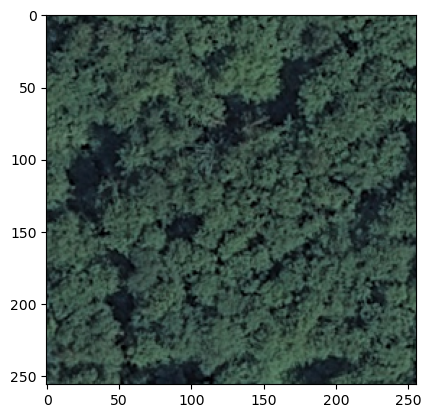

In [13]:
#satellite
experiment_name = "satellite"
import os
import random

directory = './UCMerced_LandUse/UCMerced_LandUse/Images/forest/'

file_list = os.listdir(directory)
image_files = [file for file in file_list]
random_image = "forest75.tif"#random.choice(image_files) #"151218.jpg"#

# Print the randomly selected image file
print(random_image)
img = Image.open(directory + '/' + random_image).convert("RGB") # you can use PIL to open the image

original_image = np.array(img)
original_image = Image.fromarray(original_image)

# # original_image = Image.open("/local/rcs/hc3295/mic/imagenet_sample/n01440764_10029.JPEG").convert("RGB")

original_images = [preprocess(original_image)]
original_image_input = torch.tensor(np.stack(original_images)).to(device_list[0])
original_image_arr = np.array(original_image)
plt.imshow(original_image)

# distractor
import numpy as np
dis = np.load('/local/rcs/hc3295/CLIPInterpret/data/all_words_rscid.npy')
dis = list(dis)


# all_text = pd.read_csv("milan-resnet152-imagenet-annotations.csv")["summary"].str.split(",")
# all_text_list = []
# for i in range(len(all_text)):
#     all_text_list += all_text[i]
# dis = list(pd.Series(all_text_list).unique())

ans_with_cat = dis
texts_list = [[f"this is or can be described as {i}" for i in ans_with_cat]]


forest75.tif


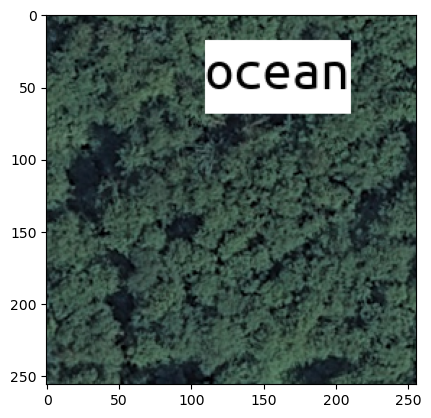

In [10]:
#satellite attack
experiment_name = "satellite_attack"
import os
import random

attack_word = "ocean"
true_class = "forest"
detect_words = ["word", "text", "a word", "a line of word", "a line of text", "a line of text on a white background", "text over white background", "black text", "black text over white background", "black alphabets", "alphabets", "letters", "black letters"]

directory = './UCMerced_LandUse/UCMerced_LandUse/Images/forest/'

file_list = os.listdir(directory)
image_files = [file for file in file_list]
random_image = random.choice(image_files) #"151218.jpg"#

# Print the randomly selected image file
print(random_image)
img = Image.open(directory + '/' + random_image).convert("RGB") # you can use PIL to open the image

original_image = np.array(img)
original_image = Image.fromarray(original_image)

fnt = ImageFont.truetype("UbuntuMono-R.ttf", 40)
I1 = ImageDraw.Draw(original_image)
text_x = random.randint(0, 150)
text_y = random.randint(0, 200)
I1.rectangle([(text_x, text_y), (text_x + 100, text_y + 50)], fill=(255, 255, 255))
I1.text((text_x, text_y), attack_word, fill=(0, 0, 0), font = fnt)


# # original_image = Image.open("/local/rcs/hc3295/mic/imagenet_sample/n01440764_10029.JPEG").convert("RGB")

original_images = [preprocess(original_image)]
original_image_input = torch.tensor(np.stack(original_images)).to(device_list[0])
original_image_arr = np.array(original_image)
plt.imshow(original_image)

# distractor
import numpy as np
dis = np.load('/local/rcs/hc3295/CLIPInterpret/data/all_words_rscid.npy')
dis = list(dis)


# all_text = pd.read_csv("milan-resnet152-imagenet-annotations.csv")["summary"].str.split(",")
# all_text_list = []
# for i in range(len(all_text)):
#     all_text_list += all_text[i]
# dis = list(pd.Series(all_text_list).unique())

ans_with_cat = dis + detect_words
texts_list = [[f"this is or can be described as {i}" for i in ans_with_cat]]


freeway03.tif


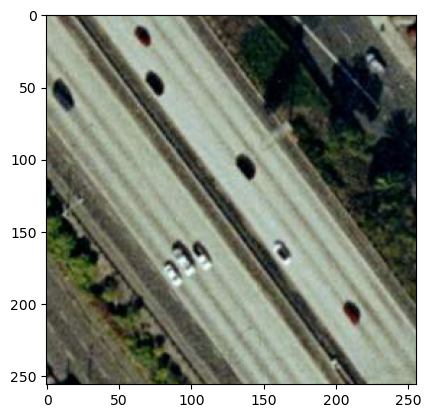

In [6]:
#satellite edit
experiment_name = "satellite_edit_with_detect_word_freeway"
import os
import random

detect_words = ["car", 
                        "automobile",
                        "motor vehicle",
                        "auto",
                        "truck",
                        "van",
                        "SUV",
                        "crossover",
                        "sedan",
                        "coupe",
                        "convertible",
                        "wagon",
                        "motorcycle",
                        "bike",
                        "bus",
                        "coach",
                        "lorry",
                        "trailer",
                        "caravan",
                        "camper",
                        "motorhome",
                        "RV",
                        "vehicles"]

directory = '/local/rcs/hc3295/mic/UCMerced_LandUse/UCMerced_LandUse/Images/freeway/'

file_list = os.listdir(directory)
image_files = [file for file in file_list]
random_image = "freeway03.tif"#"random.choice(image_files) #"151218.jpg"#

# Print the randomly selected image file
print(random_image)
img = Image.open(directory + '/' + random_image).convert("RGB") # you can use PIL to open the image


original_image = np.array(img)
original_image = Image.fromarray(original_image)
original_images = [preprocess(original_image)]
# # original_image = Image.open("/local/rcs/hc3295/mic/imagenet_sample/n01440764_10029.JPEG").convert("RGB")
original_image_input = torch.tensor(np.stack(original_images)).to(device_list[0])
original_image_arr = np.array(original_image)
plt.imshow(original_image)

# distractor
import numpy as np
dis = np.load('./CLIPInterpret/data/all_words_rscid.npy')
dis = list(dis)


# all_text = pd.read_csv("milan-resnet152-imagenet-annotations.csv")["summary"].str.split(",")
# all_text_list = []
# for i in range(len(all_text)):
#     all_text_list += all_text[i]
# dis = list(pd.Series(all_text_list).unique())

ans_with_cat = dis + detect_words
texts_list = [[f"this is or can be described as {i}" for i in ans_with_cat]]


freeway03.tif


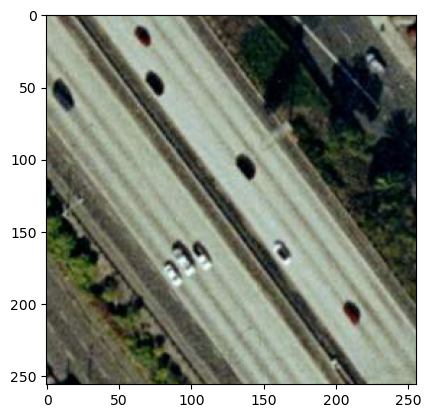

In [76]:
#satellite edit vaw vocab
experiment_name = "satellite_edit_with_detect_word_vaw_freeway"
import os
import random

detect_words = ["car", 
                        "automobile",
                        "motor vehicle",
                        "auto",
                        "truck",
                        "van",
                        "SUV",
                        "crossover",
                        "sedan",
                        "coupe",
                        "convertible",
                        "wagon",
                        "motorcycle",
                        "bike",
                        "bus",
                        "coach",
                        "lorry",
                        "trailer",
                        "caravan",
                        "camper",
                        "motorhome",
                        "RV",
                        "vehicles"]

directory = '/local/rcs/hc3295/mic/UCMerced_LandUse/UCMerced_LandUse/Images/freeway/'

file_list = os.listdir(directory)
image_files = [file for file in file_list]
random_image = "freeway03.tif"#"random.choice(image_files) #"151218.jpg"#

# Print the randomly selected image file
print(random_image)
img = Image.open(directory + '/' + random_image).convert("RGB") # you can use PIL to open the image


original_image = np.array(img)
original_image = Image.fromarray(original_image)
original_images = [preprocess(original_image)]
# # original_image = Image.open("/local/rcs/hc3295/mic/imagenet_sample/n01440764_10029.JPEG").convert("RGB")
original_image_input = torch.tensor(np.stack(original_images)).to(device_list[0])
original_image_arr = np.array(original_image)
plt.imshow(original_image)

# distractor
import numpy as np
dis = np.load('/local/rcs/hc3295/CLIPInterpret/data/all_words_rscid.npy')
dis2 = np.load('/local/rcs/hc3295/CLIPInterpret/data/all_words_vaw.npy')
dis = list(dis)


# all_text = pd.read_csv("milan-resnet152-imagenet-annotations.csv")["summary"].str.split(",")
# all_text_list = []
# for i in range(len(all_text)):
#     all_text_list += all_text[i]
# dis = list(pd.Series(all_text_list).unique())

ans_with_cat = dis + detect_words + list(dis2)
texts_list = [[f"this is or can be described as {i}" for i in ans_with_cat]]


freeway03.tif


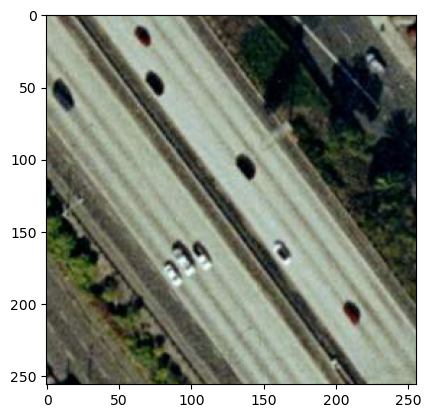

In [91]:
#satellite edit milan vocab
experiment_name = "satellite_edit_with_detect_word_milan_freeway"
import os
import random

detect_words = ["car", 
                        "automobile",
                        "motor vehicle",
                        "auto",
                        "truck",
                        "van",
                        "SUV",
                        "crossover",
                        "sedan",
                        "coupe",
                        "convertible",
                        "wagon",
                        "motorcycle",
                        "bike",
                        "bus",
                        "coach",
                        "lorry",
                        "trailer",
                        "caravan",
                        "camper",
                        "motorhome",
                        "RV",
                        "vehicles"]

directory = '/local/rcs/hc3295/mic/UCMerced_LandUse/UCMerced_LandUse/Images/freeway/'

file_list = os.listdir(directory)
image_files = [file for file in file_list]
random_image = "freeway03.tif"#"random.choice(image_files) #"151218.jpg"#

# Print the randomly selected image file
print(random_image)
img = Image.open(directory + '/' + random_image).convert("RGB") # you can use PIL to open the image


original_image = np.array(img)
original_image = Image.fromarray(original_image)
original_images = [preprocess(original_image)]
# # original_image = Image.open("/local/rcs/hc3295/mic/imagenet_sample/n01440764_10029.JPEG").convert("RGB")
original_image_input = torch.tensor(np.stack(original_images)).to(device_list[0])
original_image_arr = np.array(original_image)
plt.imshow(original_image)

# distractor
import numpy as np
dis = np.load('/local/rcs/hc3295/CLIPInterpret/data/all_words_rscid.npy')
dis2 = np.load('/local/rcs/hc3295/CLIPInterpret/data/milan_text.npy')
dis = list(dis)


# all_text = pd.read_csv("milan-resnet152-imagenet-annotations.csv")["summary"].str.split(",")
# all_text_list = []
# for i in range(len(all_text)):
#     all_text_list += all_text[i]
# dis = list(pd.Series(all_text_list).unique())

ans_with_cat = dis + detect_words + list(dis2)
texts_list = [[f"this is or can be described as {i}" for i in ans_with_cat]]


2368930.jpg


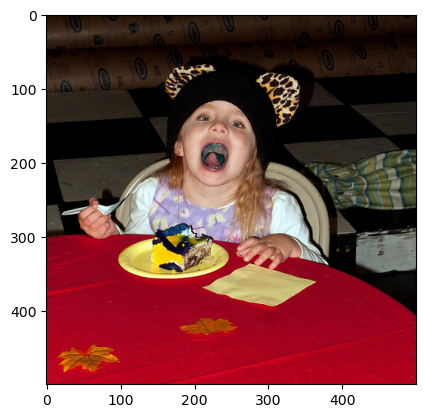

In [53]:
#milan any image
import os
import random

experiment_name = "vaw"
directory = '/local/rcs/hc3295/CLIPInterpret/vaw_images/'

file_list = os.listdir(directory)
image_files = [file for file in file_list if file.endswith(('.jpg', '.jpeg', '.png'))]
random_image = random.choice(image_files)#"ILSVRC2012_val_00038060.JPEG"# #"151218.jpg"#

# Print the randomly selected image file
print(random_image)
img = Image.open(directory + '/' + random_image).convert("RGB") # you can use PIL to open the image

original_image = np.array(img)
original_image = Image.fromarray(original_image)

# # original_image = Image.open("/local/rcs/hc3295/mic/imagenet_sample/n01440764_10029.JPEG").convert("RGB")

original_images = [preprocess(original_image)]
original_image_input = torch.tensor(np.stack(original_images)).to(device_list[0])
original_image_arr = np.array(original_image)
plt.imshow(original_image)

# distractor
import numpy as np
dis = np.load('../../CLIPInterpret/data/all_words_descriptors.npy')
# # dis = list(np.random.choice(dis, 1000))
dis = list(dis)


all_text = pd.read_csv("milan-resnet152-imagenet-annotations.csv")["summary"].str.split(",")
all_text_list = []
for i in range(len(all_text)):
    all_text_list += all_text[i]
dis = list(pd.Series(all_text_list).unique())

ans_with_cat = dis
texts_list = [[f"this is or can be described as {i}" for i in ans_with_cat]]


In [15]:
print(random_image)
import pandas
df = pd.DataFrame(texts_all_layers).T

path = f"result_for_graphing/{experiment_name}_{random_image}"
!rm -rf $path
!mkdir $path
df.to_csv(f"result_for_graphing/{experiment_name}_{random_image}/texts_all_layers.csv", index=False)
# src_img_dir = f"/local/rcs/hc3295/celebA/img_align_celeba/img_align_celeba/" + random_image
src_img_dir = directory + random_image

target_img_dir = f"result_for_graphing/{experiment_name}_{random_image}/{random_image}.jpg"
text_img_dir = f"result_for_graphing/{experiment_name}_{random_image}/{random_image}_text.jpg"

if "attack" not in experiment_name:
    !cp  $src_img_dir $target_img_dir
else:
    !cp  $src_img_dir $target_img_dir
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(original_image)
    plt.savefig(text_img_dir, bbox_inches='tight', pad_inches=0)

forest75.tif


In [18]:
# path = f"result_for_graphing/{experiment_name}_{random_image}"
# target_img_dir = f"result_for_graphing/{experiment_name}_{random_image}/{random_image}.jpg"
# text_img_dir = f"result_for_graphing/{experiment_name}_{random_image}/{random_image}_text.jpg"

In [21]:
torch.nn.__path__

['/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/torch/nn']

In [ ]:

attn_path = "attn"
files = os.listdir(attn_path)
n_tokens = 50
n_layers = 12
top_k = 10
beam_search = True
n_layers = 12

from_layer_list = []
from_token_list = []
to_layer_list = []
to_token_list = []

for layer in range(len(attns)):
    for token_i in range(n_tokens):
        for token_j in range(n_tokens):
            from_layer_list.append(layer)
            from_token_list.append(token_i)
            to_layer_list.append(layer + 1)
            to_token_list.append(token_j)

df = pd.DataFrame({"from_layer": from_layer_list, "from_token": from_token_list, "to_layer": to_layer_list, "to_token": to_token_list})
df.to_csv(f"result_for_graphing/{experiment_name}_{random_image}/attn.csv", index=False)

In [23]:
pd.DataFrame(texts_all_layers).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,a zoomed in close up of a cheetah,a zoomed in close up of a cheetah,a zoomed in close up of a cheetah,a zoomed in close up of a cheetah,a zoomed in close up of a cheetah,a zoomed in close up of a cheetah,a zoomed in close up of a cheetah,a zoomed in close up of a cheetah,a zoomed in close up of a cheetah,a woman's shoulder. rows of crops in field,uniform color or shaded from blue to white,uniform color or shaded from blue to white,a group of cars
1,tables of vegetables for sell in a market,red and black cushions and animals,a curtain in a theater,a curtain in a theater,a curtain in a theater,red and purple areas,red and black cushions and animals,human legs and the circles of color,buildings and poles,a old pho with tractors,a shirtless man pushing a lawnmower,a station with lettering on theground,a car in the grass
2,spots that contain blue and grey,tables of vegetables for sell in a market,tables of vegetables for sell in a market,tiles on a ceiling,tiles on a ceiling,black numbers on vehicles,person on a web page holding flowers,the space above a man's shoulder on a magazine,parts of background images that are light colo...,patches of skin or clothing,structures by trees outside and human activity,middle eastern style buildings,space of a license plate of a car
3,spots that contain blue and grey,red and black cushions and animals,a rack full of weights in a gym,intricate designs of a chair,a rack full of weights in a gym,a spider web,light colored spots on animals ears and buildings,diagonal and curved lines in animals or wicker...,windows of a building that look like a giant w...,structures by trees outside and human activity,tires of a 4 wheeler,things that are the color purple,a section of paint of an orange beautiful truck
4,spots that contain blue and grey,red and black cushions and animals,tiles on a ceiling,tiles on a ceiling,a rack full of weights in a gym,red and black cushions and animals,noses and shiny metal objects,black patterns on vehicles and buildings,a rack full of weights in a gym,tree branches around power lines,the lines on the zebras and the horizontal lin...,blue and green backgrounds,a section of paint of an orange beautiful truck
5,spots that contain blue and grey,tables of vegetables for sell in a market,tiles on a ceiling,a curtain in a theater,a rack full of weights in a gym,red and black cushions and animals,legs of people and water in a background,chairs on a porch,windows of a building that look like a giant w...,a greenhouse with a dog standing in front,tree branches around power lines,tree branches around power lines,a rack full of weights in a gym
6,tables of vegetables for sell in a market,legs of people and water in a background,red and black cushions and animals,columns of slats running in a vertical pattern,blue backgrounds,chairs on a porch,legs of people and water in a background,buildings and faces,windows of a building that look like a giant w...,tree branches around power lines,tree branches around power lines,a cross on the front of a church,blue and orange objects
7,spots that contain blue and grey,legs of people and water in a background,a curtain in a theater,curtains in ar oom,red and black cushions and animals,frosting and buildings,upper regions of the sky above some trees and ...,backgrounds and holes in fences,flocks of birds in a sky,legs of people and water in a background,dog standing in grass,green grass and military jackets,a group of cars
8,red and black cushions and animals,space on the front of a musician's shirt,lots of heads and eyes of various mammals,a pattern made from multiples of the same object,a rack full of weights in a gym,tables of vegetables for sell in a market,people pose for a photo with or without animals,archways of buildings and towers,a rack full of weights in a gym,green areas on an object or animal,piles of plants or legs,piles of plants or legs,parking meter
9,diagonal and curved lines in animals or wicker...,s